In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from enum import IntEnum
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import trange
from collections import defaultdict

from GrU_nn import neuralGrU
from GrU import (evaluate, GrU)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

### Load auction data

In [3]:
class clock( IntEnum ):
    pv = 0
    storage = 1
    charge = 2
    discharge = 3

class source( IntEnum ):
    grid =  0
    pv = 1
    storage = 2
    charge = 3
    discharge = 4

df_auctioneer_data = pd.read_csv('../data/Auctioneer Data.csv')

headers = np.load(file='../data/clock_data_columns.npy', allow_pickle=True)
df_clock_data = pd.DataFrame(np.load('../data/clock_data_values.npy', allow_pickle=True), columns=headers)

def getPriceVectors(round):
    '''
    Get price vectors for a round from the clock data.

    Parameters
    ----------
    round : int
        Round number to get the price vectors for, range = [0, 308]

    Returns
    -------
    prices : ndarray of shape (5, 24)
        Price vectors for g, p, s, c, d.
    
    '''
    prices = np.ndarray((5, 24))
    prices[0] = df_auctioneer_data.GRID_PRICE.values
    for e in clock:
        prices[e + 1] = df_clock_data[f'price_{round}'][e]
    return prices

## Grid vs PV (no constraint)

In [15]:
def total_loss(pi_g, pi_p, pi_s, pi_c, pi_d, d_star):
    '''
    Loss = -revenue
    '''
    # r_g = pi_g * d_star[source.grid]
    r_p = pi_p * d_star[source.pv]
    r_s = pi_s * d_star[source.storage]
    r_c = pi_c * d_star[source.charge]
    r_d = pi_d * d_star[source.discharge]

    r_t = r_p + r_s + r_c + r_d
    rev = torch.sum(r_t)

    return -rev

In [16]:
# Init model
B_init = 2
eta = 1
scaler = 1
ep = np.ones(24)

model = neuralGrU(B=B_init, n_agents=1, ep=ep, gamma=[0], eta_c=eta, eta_d=eta, alpha=1e3).to(device)

In [17]:
def squash( a, scale = 2 ):
    m = min( a )
    M = max( a )

    p = np.exp( -scale )
    P = np.exp( scale )

    n = (a - m)/(M-m) * 2 * scale
    n = np.exp( n - scale )

    return (n - p) / (P - p) * (M - m) + m

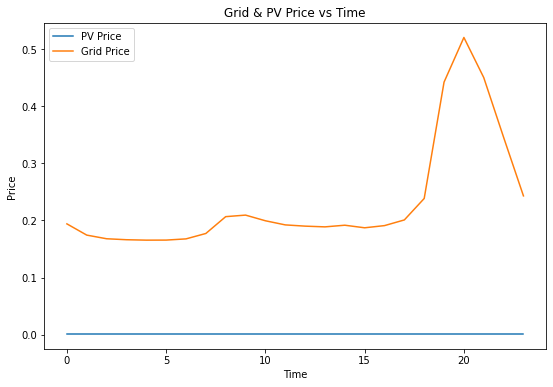

In [18]:
# Price vectors from Auction Data
prices = getPriceVectors(300) * scaler

# Scale grid prices with non-linear min-max scaler
prices[source.grid] = squash(prices[source.grid], scale=2)

# Init grid price close to 0
prices[source.pv] = 1e-3

# Init Charge, discharge & storage to inf
prices[source.charge:] = 1e6

plt.figure(figsize=(9,6))
plt.title('Grid & PV Price vs Time')
plt.plot(prices[source.pv], label='PV Price')
plt.plot(prices[source.grid], label='Grid Price')
plt.ylabel('Price')
plt.xlabel('Time')
plt.legend()
plt.show()

In [19]:
# Total demand tensor (Unit)
d_t = torch.ones((1, 24), requires_grad=False, device=device) 

# # Cap tensor
# C_p = torch.ones((1, 24), requires_grad=False) * 4

# Price tensors
pi_g = torch.tensor(prices[source.grid], requires_grad=False, device=device)

pi_p = torch.tensor(prices[source.pv],  requires_grad=True, device=device)
pi_c = torch.tensor(prices[source.charge], requires_grad=True, device=device)
pi_d = torch.tensor(prices[source.discharge], requires_grad=True, device=device)
pi_s = torch.tensor(prices[source.storage], requires_grad=True, device=device)

#### Optimisation schedule

In [20]:
# Hyperparameter(s)
learning_rate = 0.01
epochs = 250

history = []
best_loss = 0
model.B = B_init

# Init optimizer & scheduler
optimizer = torch.optim.Adam([pi_p, pi_s, pi_c, pi_d], lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)

for t in trange(epochs):
    # Compute prediction and loss
    d_star = model(pi_g, pi_p, pi_s, pi_c, pi_d, d_t)
    loss = total_loss(pi_g, pi_p, pi_s, pi_c, pi_d, d_star.squeeze())

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()

    # Optimisation
    optimizer.step()
    scheduler.step()

    loss = loss.item()
    history.append(loss / scaler)

    if loss < best_loss:
        pi_optimal, best_loss = [], loss
        for pi in pi_p, pi_s, pi_c, pi_d:
            pi_optimal.append(pi.clone().detach())

    # Curriculum Learning
    if t % 10 == 0 and model.B < 1e4:
        model.B *= 2

    # if t % 100 == 0:
    #     print(f"Epoch {t+1}     loss: {loss:>7f}")

100%|██████████| 250/250 [00:01<00:00, 180.80it/s]


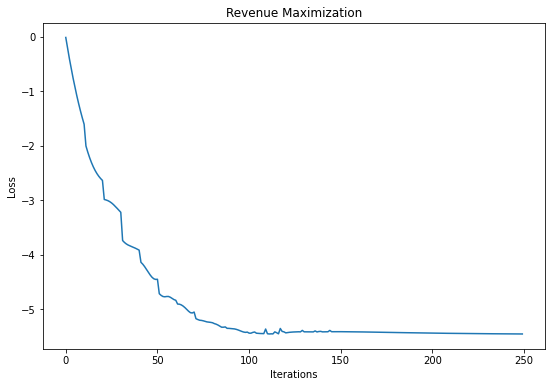

In [23]:
plt.figure(figsize=(9,6))
plt.plot(history, label='loss')
plt.title('Revenue Maximization')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

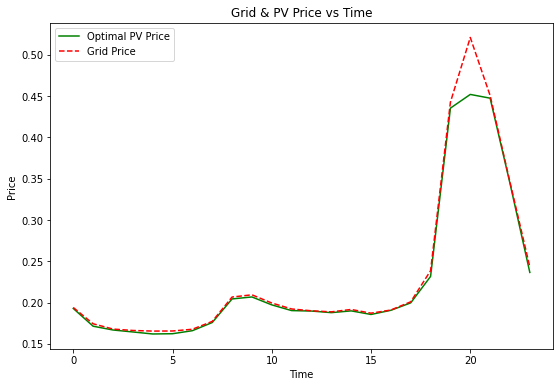

In [26]:
prices_pv_optimal = pi_optimal[0].numpy()
prices_pv_current = pi_p.detach().numpy()

plt.figure(figsize=(9,6))
plt.title('Grid & PV Price vs Time')
plt.plot(prices_pv_optimal, label='Optimal PV Price', color='green')
# plt.plot(prices_pv_current, label='Current PV Price', color='green')
plt.plot(prices[source.grid], label='Grid Price', linestyle='dashed', color='red')
plt.ylabel('Price')
plt.xlabel('Time')
plt.legend()
plt.show()

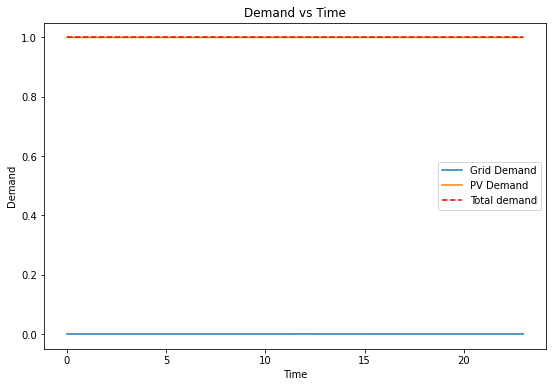

In [27]:
pi_p, pi_s, pi_c, pi_d = pi_optimal
d_star_optimal = model(pi_g, pi_p, pi_s, pi_c, pi_d, d_t).squeeze().detach().numpy()
d_total = d_t.detach().numpy().T


plt.figure(figsize=(9,6))
plt.title('Demand vs Time')
plt.plot(d_star_optimal[source.grid], label='Grid Demand')
plt.plot(d_star_optimal[source.pv], label='PV Demand')
plt.plot(d_total, label='Total demand', linestyle='dashed', color='r')
plt.ylabel('Demand')
plt.xlabel('Time')
plt.legend()
plt.show()